In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.image import load_image
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.image_classification.models.darknet19 import DarkNet19FeatureExtractor
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer
from torchlake.common.controller.recorder import TrainRecorder

from torchlake.object_detection.models.yolov2 import YOLOV2, YOLOV2Loss, PriorBox
from torchlake.object_detection.utils.plot import draw_pred

In [2]:
import random
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torchinfo

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov2')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 5

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov2",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("voc.anchors.txt").as_posix(),
)

# data

In [7]:
BATCH_SIZE = 64

In [8]:
IMAGE_SIZE = 416

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [11]:
# train_dataset.env.close()

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 416, 416]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([64, 3, 416, 416]) 64


# model

If you don't have anchors yet, build one in debug section

In [15]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["3_1", "4_1"])

In [16]:
# backbone = DarkNet19FeatureExtractor("last_conv", "../../artifacts/darknet19/darknet19_448.pth", trainable=False)
# backbone.fix_target_layers(["3_1", "4_1"])

In [17]:
model = YOLOV2(
    backbone,
    CONTEXT,
    backbone.feature_dims[-2:],
).to(CONTEXT.device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV2                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        221,952
│    │    └─Sequential: 3-3                        1,116,416
│    │    └─Sequential: 3-4                        6,822,400
│    │    └─Sequential: 3-5                        13,114,368
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─ModuleDict: 1-2                                  --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-7              8,256
│    │    └─StackedPatch2d: 3-8                    --
│    └─Sequential: 2-4                             --
│    │    └─Conv2dNormActivation: 3-9              4,720,640
│    │    └─Conv2dNormActivation: 3-1

# train

In [19]:
EPOCH = 30

In [20]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [21]:
recorder = TrainRecorder(0, EPOCH, num_loss=5)
recorder.increment_data_size(len(train_dataset))

In [22]:
# underestimate the loss, since we drop last batch
recorder.data_size

16551

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOV2Loss(CONTEXT)

In [24]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [25]:
scaler = torch.cuda.amp.GradScaler()

In [26]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 258/258 [02:53<00:00,  1.49it/s]


------------------------------------
Epoch 1
------------------------------------
27.60002311857275 (0%)
1.8051499299978278 (0%)
22.531891725148444 (0%)
0.4636161083772055 (0%)
0.944901057610908 (0%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 2
------------------------------------
4.937159363276055 (-82%)
1.3077838255353484 (-28%)
1.366065863532736 (-94%)
0.38496459697958274 (-17%)
0.3384866962821221 (-64%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 3
------------------------------------
3.601273159211254 (-27%)
0.8757971064733678 (-33%)
0.9027699291954568 (-34%)
0.3057698602511021 (-21%)
0.29385682378504663 (-13%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 4
------------------------------------
2.872360595496614 (-20%)
0.5933538589814041 (-32%)
0.7105805896774937 (-21%)
0.2619932681280682 (-14%)
0.2584598148404259 (-12%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 5
------------------------------------
2.515070453049387 (-12%)
0.4759995117842069 (-20%)
0.615933000929773 (-13%)
0.23832718211497786 (-9%)
0.2315020442232252 (-10%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 6
------------------------------------
2.1333318257085514 (-15%)
0.37208643859048335 (-22%)
0.5152881958356299 (-16%)
0.2093904718345229 (-12%)
0.19900483179291184 (-14%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 7
------------------------------------
1.859048316618604 (-13%)
0.3003216851737866 (-19%)
0.4480117840260135 (-13%)
0.1862818730517777 (-11%)
0.17930548509855104 (-10%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 8
------------------------------------
1.6149167357078251 (-13%)
0.2483722822204196 (-17%)
0.3915023915494406 (-13%)
0.16234265998096795 (-13%)
0.1633287636897088 (-9%)


100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


------------------------------------
Epoch 9
------------------------------------
1.4430667971003175 (-11%)
0.2133376621838445 (-14%)
0.3460178706561124 (-12%)
0.14609973131439902 (-10%)
0.15321260077392554 (-6%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 10
------------------------------------
1.2803152044131578 (-11%)
0.18166616914294065 (-15%)
0.30722419191837214 (-11%)
0.13076580396901943 (-10%)
0.13759582561709352 (-10%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 11
------------------------------------
1.1545172057463815 (-10%)
0.15771703778865526 (-13%)
0.27532183109154623 (-10%)
0.11876935073237616 (-9%)
0.12763158792916707 (-7%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 12
------------------------------------
1.0401372816777146 (-10%)
0.13748972466774034 (-13%)
0.24619979125467661 (-11%)
0.10726845288203203 (-10%)
0.12010550552261222 (-6%)


100%|██████████| 258/258 [02:43<00:00,  1.57it/s]


------------------------------------
Epoch 13
------------------------------------
0.9426810625463614 (-9%)
0.12108009678022026 (-12%)
0.22123720969874922 (-10%)
0.09729712338298052 (-9%)
0.11387814070103676 (-5%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 14
------------------------------------
0.8489683085673159 (-10%)
0.10637089076931543 (-12%)
0.19583056618544878 (-11%)
0.0881469806481917 (-9%)
0.10603194806908678 (-7%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 15
------------------------------------
0.777006373550372 (-8%)
0.0967905317524842 (-9%)
0.17644978989921556 (-10%)
0.08010404117589527 (-9%)
0.10324584677906365 (-3%)


100%|██████████| 258/258 [02:43<00:00,  1.58it/s]


------------------------------------
Epoch 16
------------------------------------
0.7262997289891184 (-7%)
0.09273443600143397 (-4%)
0.16182307806355553 (-8%)
0.0751426462089682 (-6%)
0.09602898696017587 (-7%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 17
------------------------------------
0.6696641229515774 (-8%)
0.08201996817069356 (-12%)
0.14956538873556896 (-8%)
0.06869790652145265 (-9%)
0.09458923442119861 (-1%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 18
------------------------------------
0.6109186351915104 (-9%)
0.06904059270380286 (-16%)
0.13224100560970845 (-12%)
0.06388079051229287 (-7%)
0.09023308504759295 (-5%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 19
------------------------------------
0.5691140262275786 (-7%)
0.06586290685894713 (-5%)
0.12069675893727679 (-9%)
0.059300210467134566 (-7%)
0.0860533083351665 (-5%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 20
------------------------------------
0.5325824984624871 (-6%)
0.06600204711467884 (0%)
0.11024220675026557 (-9%)
0.05467916968999457 (-8%)
0.08294239589277903 (-4%)


100%|██████████| 258/258 [02:43<00:00,  1.57it/s]


------------------------------------
Epoch 21
------------------------------------
0.5109604195982053 (-4%)
0.062302681657671805 (-6%)
0.10645412034581021 (-3%)
0.05217280319310203 (-5%)
0.0813396040834795 (-2%)


100%|██████████| 258/258 [02:43<00:00,  1.57it/s]


------------------------------------
Epoch 22
------------------------------------
0.48040986834649274 (-6%)
0.059372070959115494 (-5%)
0.09795172830613591 (-8%)
0.04864795379685918 (-7%)
0.07984630083880763 (-2%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 23
------------------------------------
0.44992004709368816 (-6%)
0.05456526427389692 (-8%)
0.09110268909227781 (-7%)
0.045846869899285804 (-6%)
0.07501774389976729 (-6%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 24
------------------------------------
0.4229001419816909 (-6%)
0.04953377998334016 (-9%)
0.08384140656654307 (-8%)
0.0431768061869685 (-6%)
0.07364092540988736 (-2%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 25
------------------------------------
0.40498278429267515 (-4%)
0.04659071329331285 (-6%)
0.08059195171100601 (-4%)
0.04123380621223895 (-5%)
0.0716310896748726 (-3%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 26
------------------------------------
0.3872667353186793 (-4%)
0.0446584152009262 (-4%)
0.07605429759062163 (-6%)
0.03904577440944989 (-5%)
0.07132515072656909 (0%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 27
------------------------------------
0.35339666030881023 (-9%)
0.03842550831779987 (-14%)
0.06681894421987994 (-12%)
0.036260382087344056 (-7%)
0.06685029795562947 (-6%)


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]


------------------------------------
Epoch 28
------------------------------------
0.36275160615879615 (3%)
0.04891274694150096 (27%)
0.0680468199541328 (2%)
0.0357356666690323 (-1%)
0.06711370610346656 (0%)


100%|██████████| 258/258 [02:43<00:00,  1.57it/s]


------------------------------------
Epoch 29
------------------------------------
0.34591497414695926 (-5%)
0.042867191380319664 (-12%)
0.06535262247924178 (-4%)
0.034422007120452916 (-4%)
0.06558512693502765 (-2%)


100%|██████████| 258/258 [02:43<00:00,  1.57it/s]

------------------------------------
Epoch 30
------------------------------------
0.33075273621083023 (-4%)
0.03931787221746917 (-8%)
0.061767281610708887 (-5%)
0.03315306403083634 (-4%)
0.06390226096892586 (-3%)


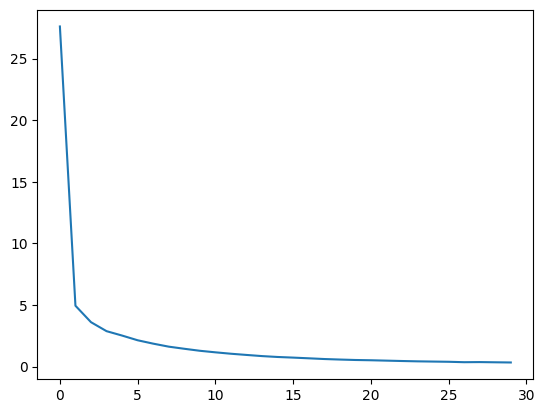

In [27]:
plt.plot(training_loss)

# save

In [28]:
from torchlake.common.controller.weight_manager import WeightManager

In [29]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{epoch}.mse.pth").as_posix())

In [30]:
model_path = manager.get_filename(
    detector_name=CONTEXT.detector_name,
    backbone_name=backbone.network_name,
    # epoch=recorder.current_epoch,
    epoch=EPOCH,
)

In [31]:
model_path

WindowsPath('../../artifacts/yolov2/yolov2.resnet34.30.mse.pth')

In [32]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.30.mse.pth, model size is 176.41MiB


In [33]:
manager.load_weight(model_path, model)

# Inference

In [34]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [35]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [36]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [48]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="yolo",
    #     # min_area=1024,
    #     # min_visibility=0.3,
    # ),
)

In [38]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [39]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [49]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [41]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [42]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B x (?, 25)
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/77 [00:01<?, ?it/s]


In [43]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     decoded = decoder.decode(output.cpu(), (224, 224))
#     boxes = decoded[0]
#     # boxes = output[0].unflatten(0, (5, 25)).permute(0, 2, 3, 1).reshape(-1, 25)
#     print(boxes[boxes[:, 4] > 0.1])

In [44]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

person: 0.42
person: 0.45
dog: 0.73
sheep: 0.51
sheep: 0.36
sheep: 0.67
dog: 0.56
motorbike: 0.55
car: 0.48
car: 0.83
car: 0.42
car: 0.44
pottedplant: 0.65
aeroplane: 0.51
aeroplane: 0.31
person: 0.51
bus: 0.70
bus: 0.68
horse: 0.71
tvmonitor: 0.32
person: 0.48
person: 0.60
cat: 0.77
person: 0.75
tvmonitor: 0.61
aeroplane: 0.39
horse: 0.43
bicycle: 0.77
tvmonitor: 0.64
cow: 0.33
horse: 0.50
horse: 0.71
person: 0.64
tvmonitor: 0.59
pottedplant: 0.34
train: 0.52
chair: 0.34
chair: 0.46
horse: 0.39
horse: 0.49
horse: 0.74
person: 0.59
chair: 0.31
chair: 0.50
diningtable: 0.42
person: 0.38
person: 0.83
person: 0.72
person: 0.37
person: 0.66
person: 0.58
bird: 0.72
aeroplane: 0.57
chair: 0.35
person: 0.58
person: 0.50
sheep: 0.77
person: 0.44
person: 0.67
chair: 0.36
chair: 0.58
chair: 0.62
person: 0.39
person: 0.37
person: 0.51
person: 0.44
pottedplant: 0.38
pottedplant: 0.39
person: 0.46
sheep: 0.61
sheep: 0.34
sheep: 0.36
car: 0.85
bus: 0.44
car: 0.37
person: 0.53
person: 0.59
horse: 0.3

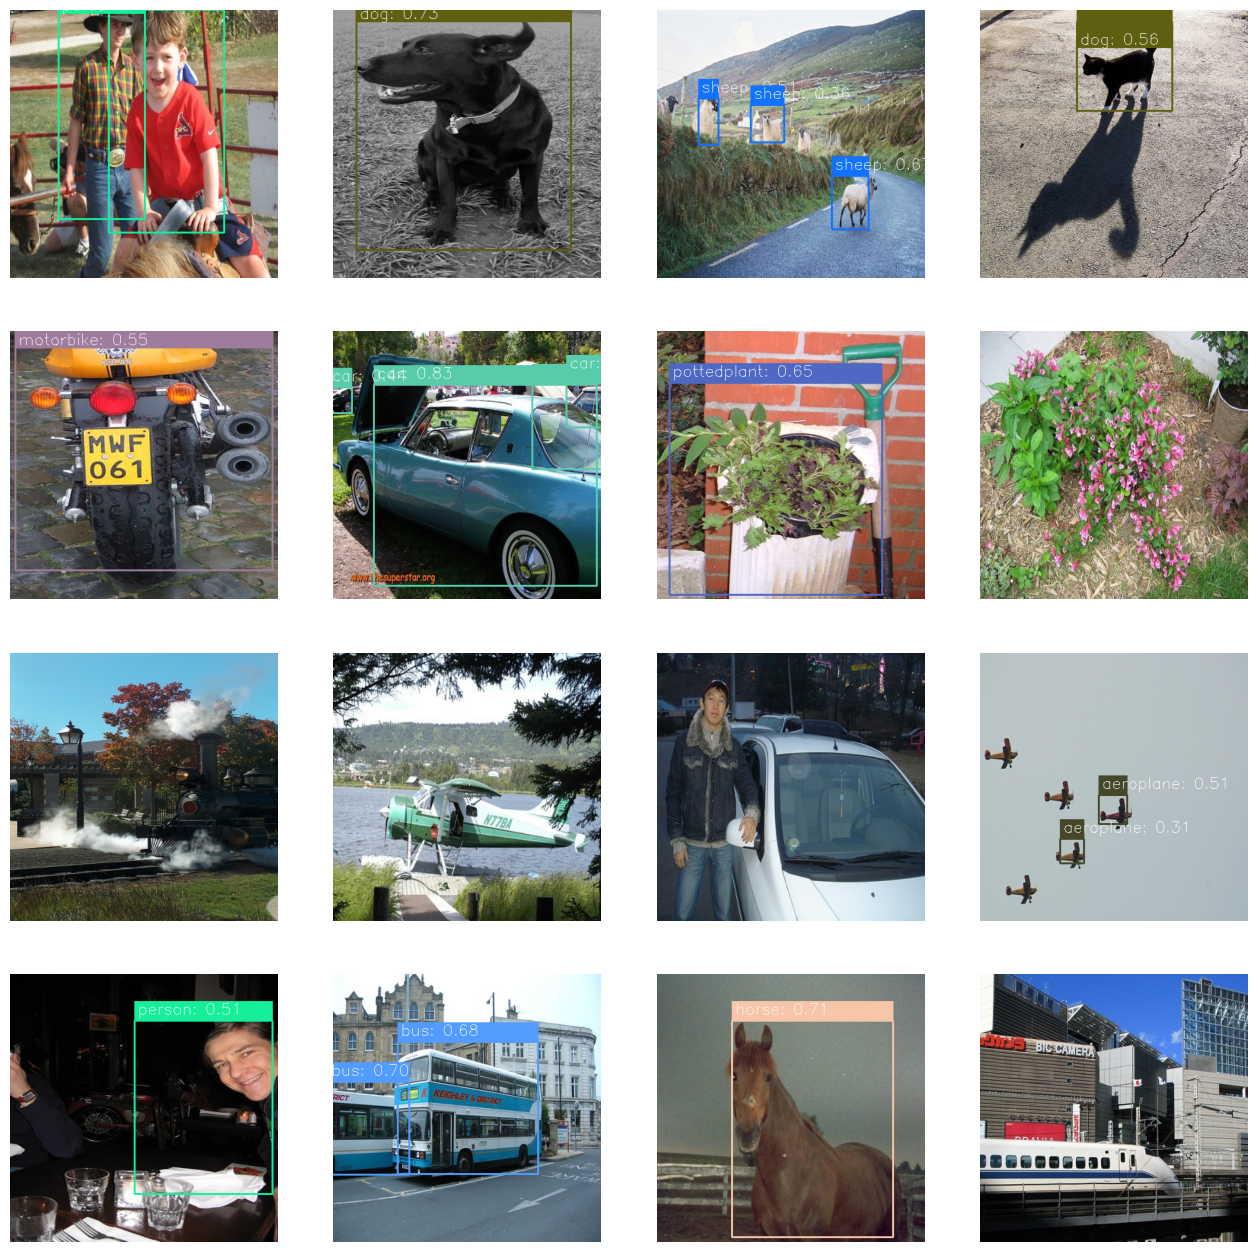

In [45]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [50]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.36
person: 0.75
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 0.42
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.64
aeroplane: 0.49
aeroplane: 0.42
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 3


In [ ]:
# predictor.predict_video_file(
#     model,
#     "../../data/movie.mp4",
#     VOC_CLASS_NAMES,
#     color_map,
#     test_transform,
#     show=False,
#     save_dir=artifact_path.as_posix(),
# )

# evaluate

In [70]:
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [ ]:
VAL_IMAGE_SIZE = 448

In [72]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [73]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [74]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [75]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    # shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [77]:
evaluator = Evaluator(CONTEXT)

In [78]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [01:35<00:00,  1.22s/it]

       aeroplane   bicycle      bird      boat    bottle       bus      car  \
AP@0.5    0.4096  0.498389  0.494759  0.418018  0.335003  0.404806  0.41885   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.427049  0.418357  0.417445  ...  0.423766  0.497201  0.500355   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.491452    0.486474  0.486953  0.486254  0.488464   0.48941  0.450521  

[1 rows x 21 columns]


In [79]:
result_table.T

,AP@0.5
aeroplane,0.4096
bicycle,0.498389
bird,0.494759
boat,0.418018
bottle,0.335003
bus,0.404806
car,0.41885
cat,0.427049
chair,0.418357
cow,0.417445


# further evaluation

# debug

## draw anchors

In [26]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
)

In [27]:
if not (Path(CONTEXT.anchors_path).exists() and Path(CONTEXT.anchors_path).is_file()):
    p = PriorBox(CONTEXT)
    anchors = p.build_anchors(train_dataset.table[["w", "h"]].to_numpy())
    p.save_anchors(anchors)

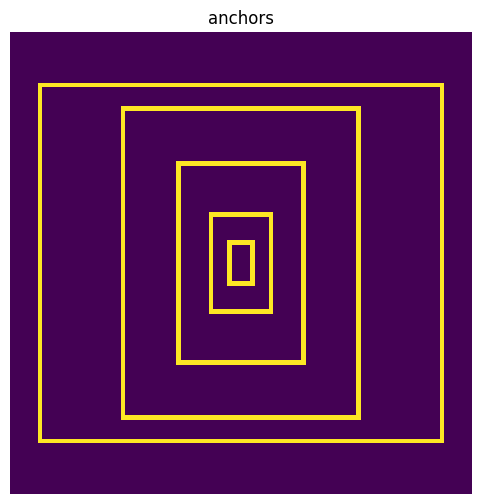

In [28]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.yolov2 import PriorBox
from torchlake.object_detection.utils.config import load_anchors
from torchlake.common.utils.plot import plot_grids

box = PriorBox(CONTEXT)
anchors = load_anchors(CONTEXT.anchors_path)

canvas = [draw_anchors(anchors)]

plot_grids(
    canvas,
    ["anchors"],
    1,
    1,
    figsize=(8,6),
)

## match

In [57]:
from torchlake.object_detection.utils.train import build_flatten_targets
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.object_detection.utils.plot import draw_label
from torchlake.object_detection.utils.train import generate_grid_train

In [58]:
criterion = YOLOV2Loss(CONTEXT)

In [151]:
for x, y in train_loader:
    break

In [152]:
t, span = build_flatten_targets(y, (13, 13), delta_coord=True)

In [153]:
cloned_image = img_tensor_to_np(x[0])

In [154]:
matched = criterion.match(t.to(CONTEXT.device), span, 13, 13)

In [170]:
matched[0].reshape(-1, 7).shape

torch.Size([845, 7])

In [155]:
# candidate index among A*H*W
candidates = torch.arange(845).to(CONTEXT.device)[matched[0, :, 6] == 1]

In [156]:
# anchor matched target
matched_gts =  matched[0, matched[0, :, 6] == 1, :]

In [157]:
anchors_no, cells_no = candidates // (13 * 13), candidates % (13*13)
anchors_no, cells_no

(tensor([0, 0, 0, 0, 2, 2], device='cuda:0'),
 tensor([ 67, 132, 137, 140,  99, 110], device='cuda:0'))

In [158]:
anchors_cxcy = generate_grid_train(13, 13, center=True).permute(0, 1, 3, 4, 2).reshape(-1, 2).repeat(CONTEXT.num_anchors, 1).to(CONTEXT.device)

In [159]:
matched_anchors = criterion.anchors[:, anchors_no].permute(0, 1, 3, 4, 2).reshape(-1, 2)

In [160]:
anchors_cxcy = anchors_cxcy[(anchors_no*13**2+cells_no).long()]
anchors_xy = anchors_cxcy - matched_anchors / 2
matched_anchors = torch.cat([anchors_xy, matched_anchors], -1)

In [161]:
matched_anchors

tensor([[0.0608, 0.2067, 0.2630, 0.4328],
        [0.0608, 0.5913, 0.2630, 0.4328],
        [0.4454, 0.5913, 0.2630, 0.4328],
        [0.6762, 0.5913, 0.2630, 0.4328],
        [0.5937, 0.4739, 0.1203, 0.2060],
        [0.4398, 0.5509, 0.1203, 0.2060]], device='cuda:0')

In [162]:
matched_gts[:, 2:4] = matched_gts[:, 2:4].exp() * matched_anchors[:, 2:4]
matched_gts[:, :2] = matched_gts[:, :2] + (matched_anchors[:, :2] - 0.5 /13) # - matched_gts[:, 2:4]/2 

In [163]:
matched_gts

tensor([[ 0.0645,  0.2336,  0.2213,  0.4320, 14.0000,  0.7496,  1.0000],
        [ 0.0525,  0.5836,  0.3680,  0.4000,  1.0000,  0.6752,  1.0000],
        [ 0.4311,  0.5606,  0.2240,  0.4420, 14.0000,  0.7483,  1.0000],
        [ 0.6978,  0.5556,  0.3360,  0.4560, 14.0000,  0.6738,  1.0000],
        [ 0.6052,  0.4360,  0.1520,  0.2820, 14.0000,  0.5783,  1.0000],
        [ 0.4078,  0.5200,  0.0400,  0.1420, 14.0000,  0.2291,  1.0000]],
       device='cuda:0')

In [164]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_gts[:, :4], torch.zeros(num_gt, 1).to(CONTEXT.device)], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0,128,128), "anchor": (128, 0, 0)},
    class_show=False,
)

In [165]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_anchors[:, :4], torch.ones(num_gt, 1).to(CONTEXT.device)], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0,128,128), "anchor": (128, 0, 0)},
    class_show=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


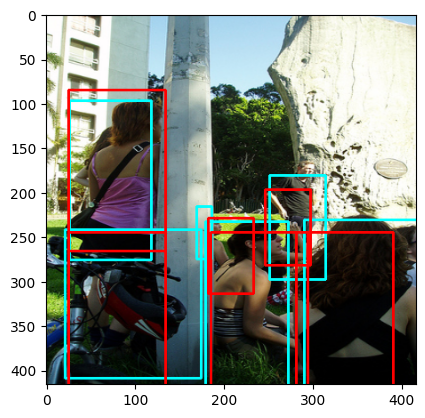

In [166]:
plt.imshow(cloned_image)